<a href="https://colab.research.google.com/github/Ranjita2022/Dental-Cavity-Detection-Using-Instance-Segmentation-and-Object-detection/blob/main/yolo11_od.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# After running this, you'll get a link to authorize access to your Google Drive.
# Once authorized, your Google Drive will be available under '/content/drive/My Drive'


Mounted at /content/drive


In [ ]:
import tarfile

tar_path ='/content/drive/MyDrive/MyDataset/dentalai-DatasetNinja.tar'  # Update this path
extract_path = '/content/dataset/'  # Where you want to extract the files

with tarfile.open(tar_path, 'r') as tar_ref:
    tar_ref.extractall(extract_path)

In [ ]:
!nvidia-smi

Tue Oct  1 13:03:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='/content/dataset/test/img/1012_jpg.rf.8ed3d51db93a4be67e7083ed329c6039.jpg' save=True

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

image 1/1 /content/dataset/test/img/1012_jpg.rf.8ed3d51db93a4be67e7083ed329c6039.jpg: 448x640 4 donuts, 74.3ms
Speed: 5.5ms preprocess, 74.3ms inference, 776.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

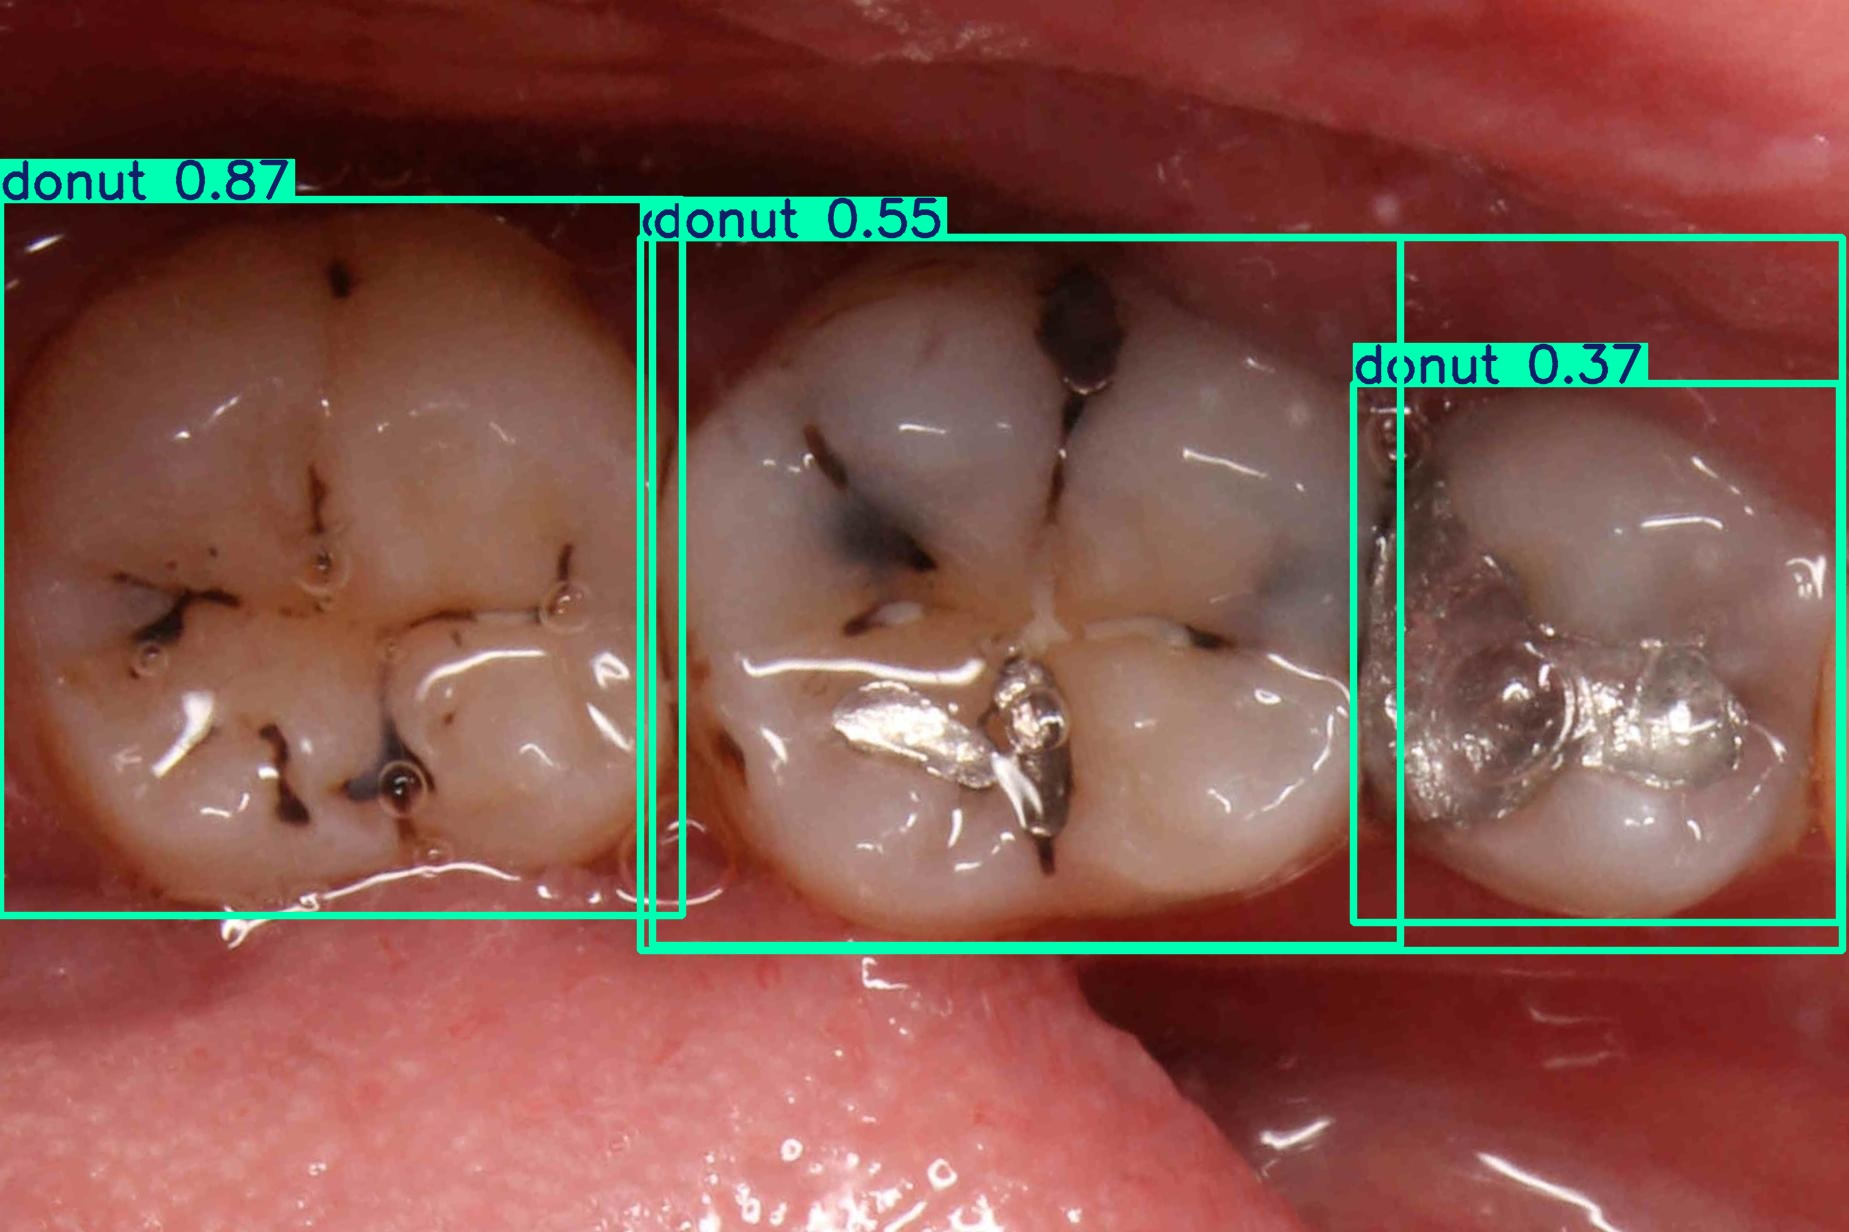

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'runs/detect/predict3/1012_jpg.rf.8ed3d51db93a4be67e7083ed329c6039.jpg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://cdn.datasetninja.com/masks?project_id=2084&image_id=4216633', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 448x640 (no detections), 85.1ms
Speed: 3.0ms preprocess, 85.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([], device='cuda:0', size=(0, 4))

In [ ]:
result.boxes.conf

tensor([], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

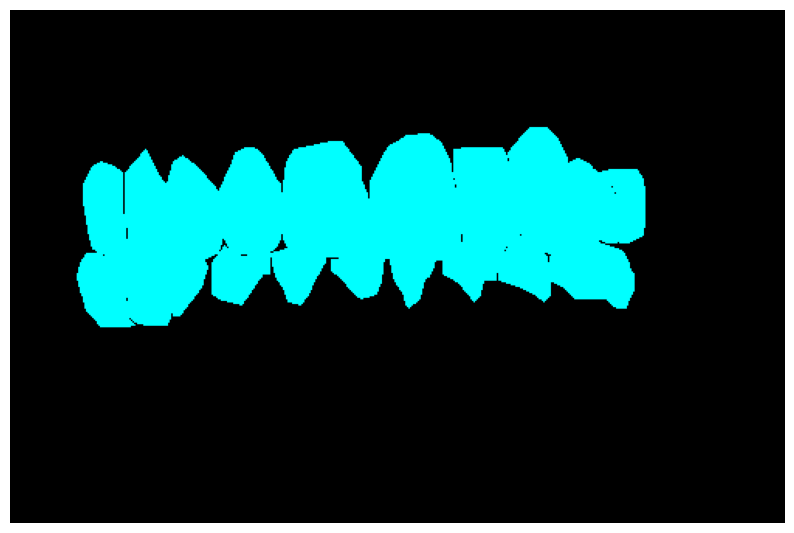

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="gJ2EgKQLeFLPrDZWMdPs")
project = rf.workspace("ranjita-infb1").project("dental-gjlh1")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Dental-1 in yolov11:: 100%|██████████| 5002/5002 [00:00<00:00, 5329.33it/s]


In [ ]:
!mkdir /content/dataset
%cd /content/dataset

from google.colab import userdata
from roboflow import Roboflow

# Retrieve your API key from Colab secrets
ROBOFLOW_API_KEY = userdata.get('gJ2EgKQLeFLPrDZWMdPs')  # This line should now work correctly

rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("ranjita-infb1")
project = workspace.project("dental-gjlh1")
version = project.version(1)
dataset = version.download("yolov11")






/content/dataset


SecretNotFoundError: Secret gJ2EgKQLeFLPrDZWMdPs does not exist.

## Custom Training

In [ ]:
!pip install ultralytics

# Test installation
!yolo --help



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.2/902.2 kB 23.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
WARNING ⚠️ argument '--help' does not require leading dashes '--', updating to 'help'.

    Arguments received: ['yolo', '--help']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of {'pose', 'classify', 'detect', 'segment', 'obb'}
                MODE (required) is one of {'predict', 'track', 'val', 'export', 'benchmark', 'train'}
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 

In [ ]:
%cd /content

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 229MB/s]
Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Dental-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls /content/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1734850120.673258a09ce5.5843.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


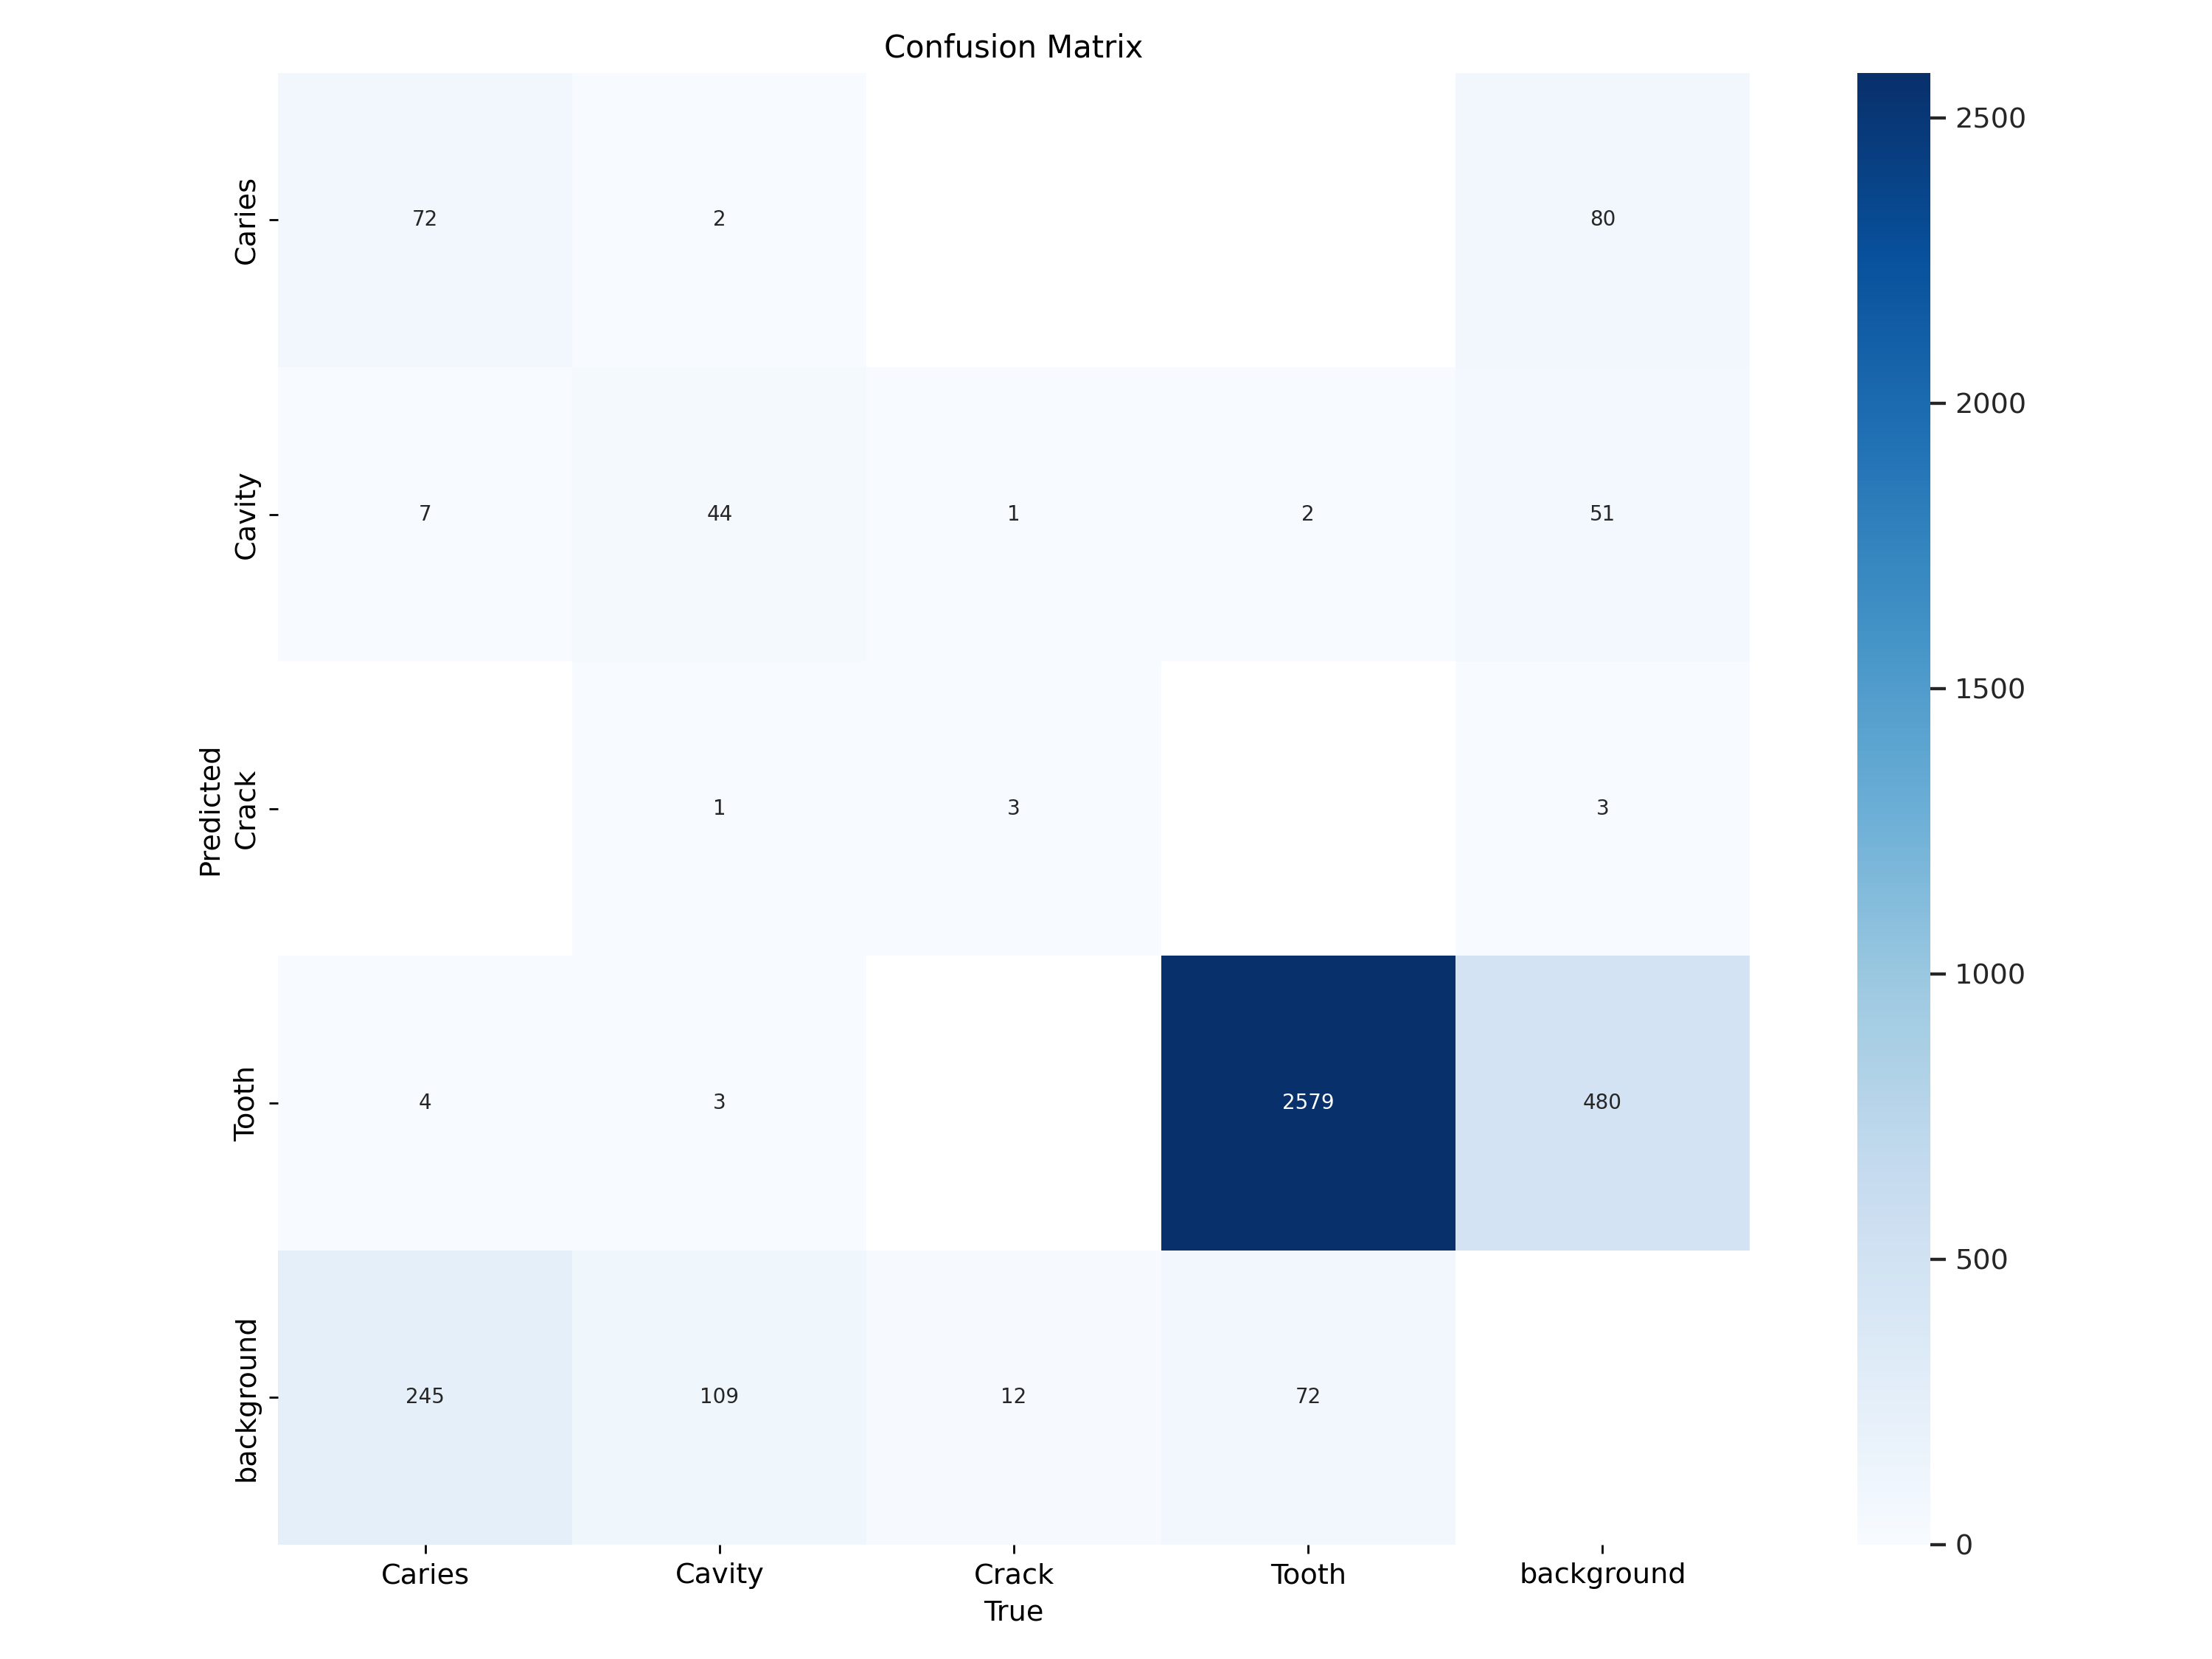

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train/confusion_matrix.png', width=600)

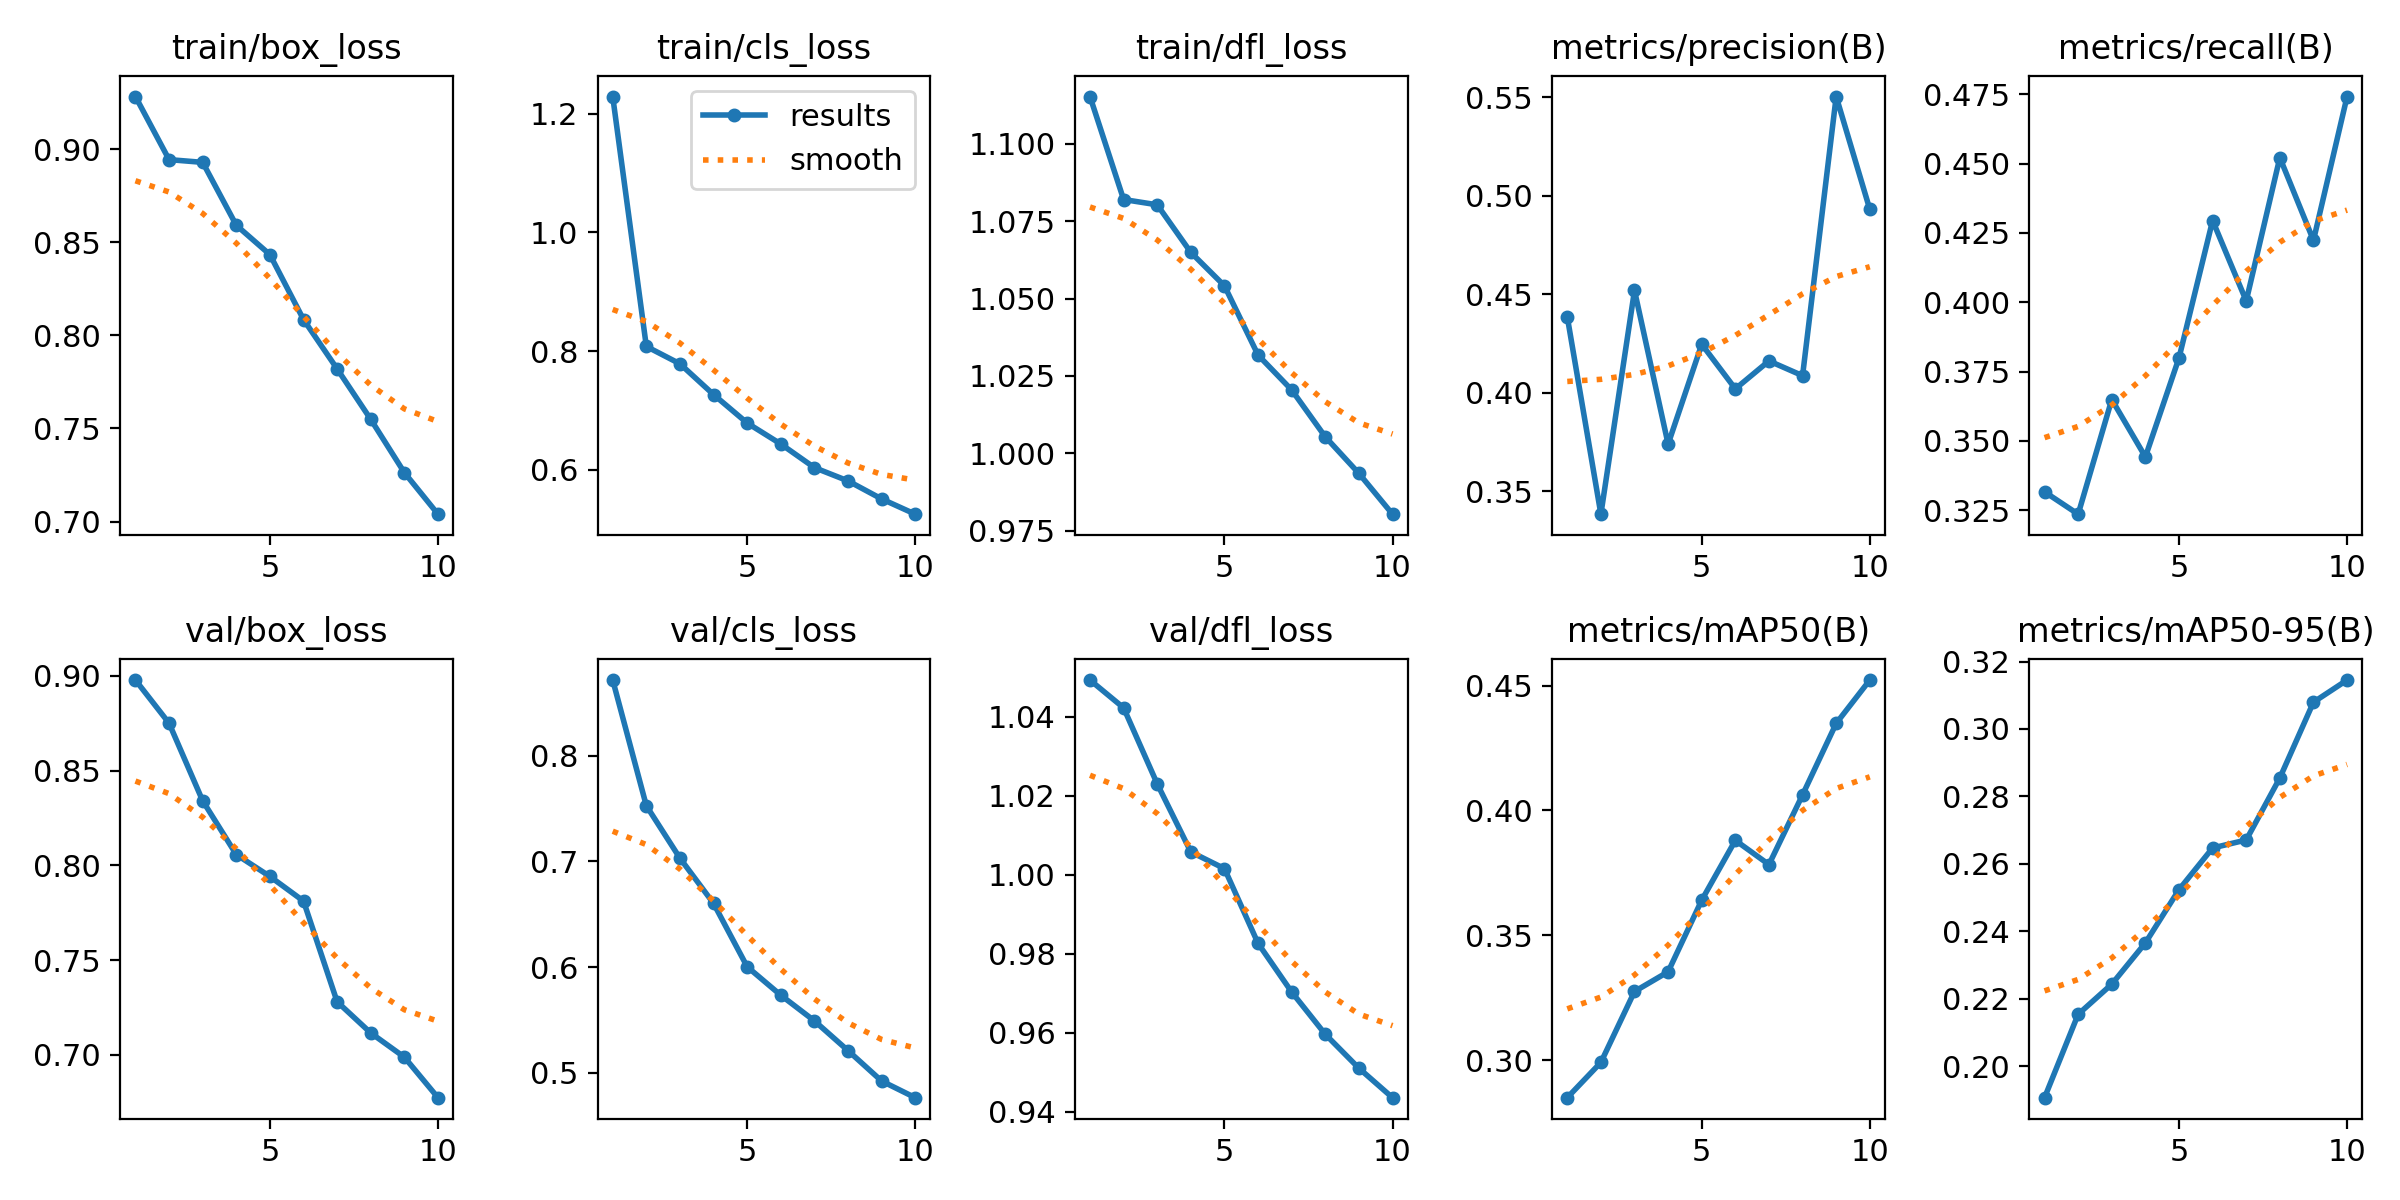

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train/results.png', width=600)

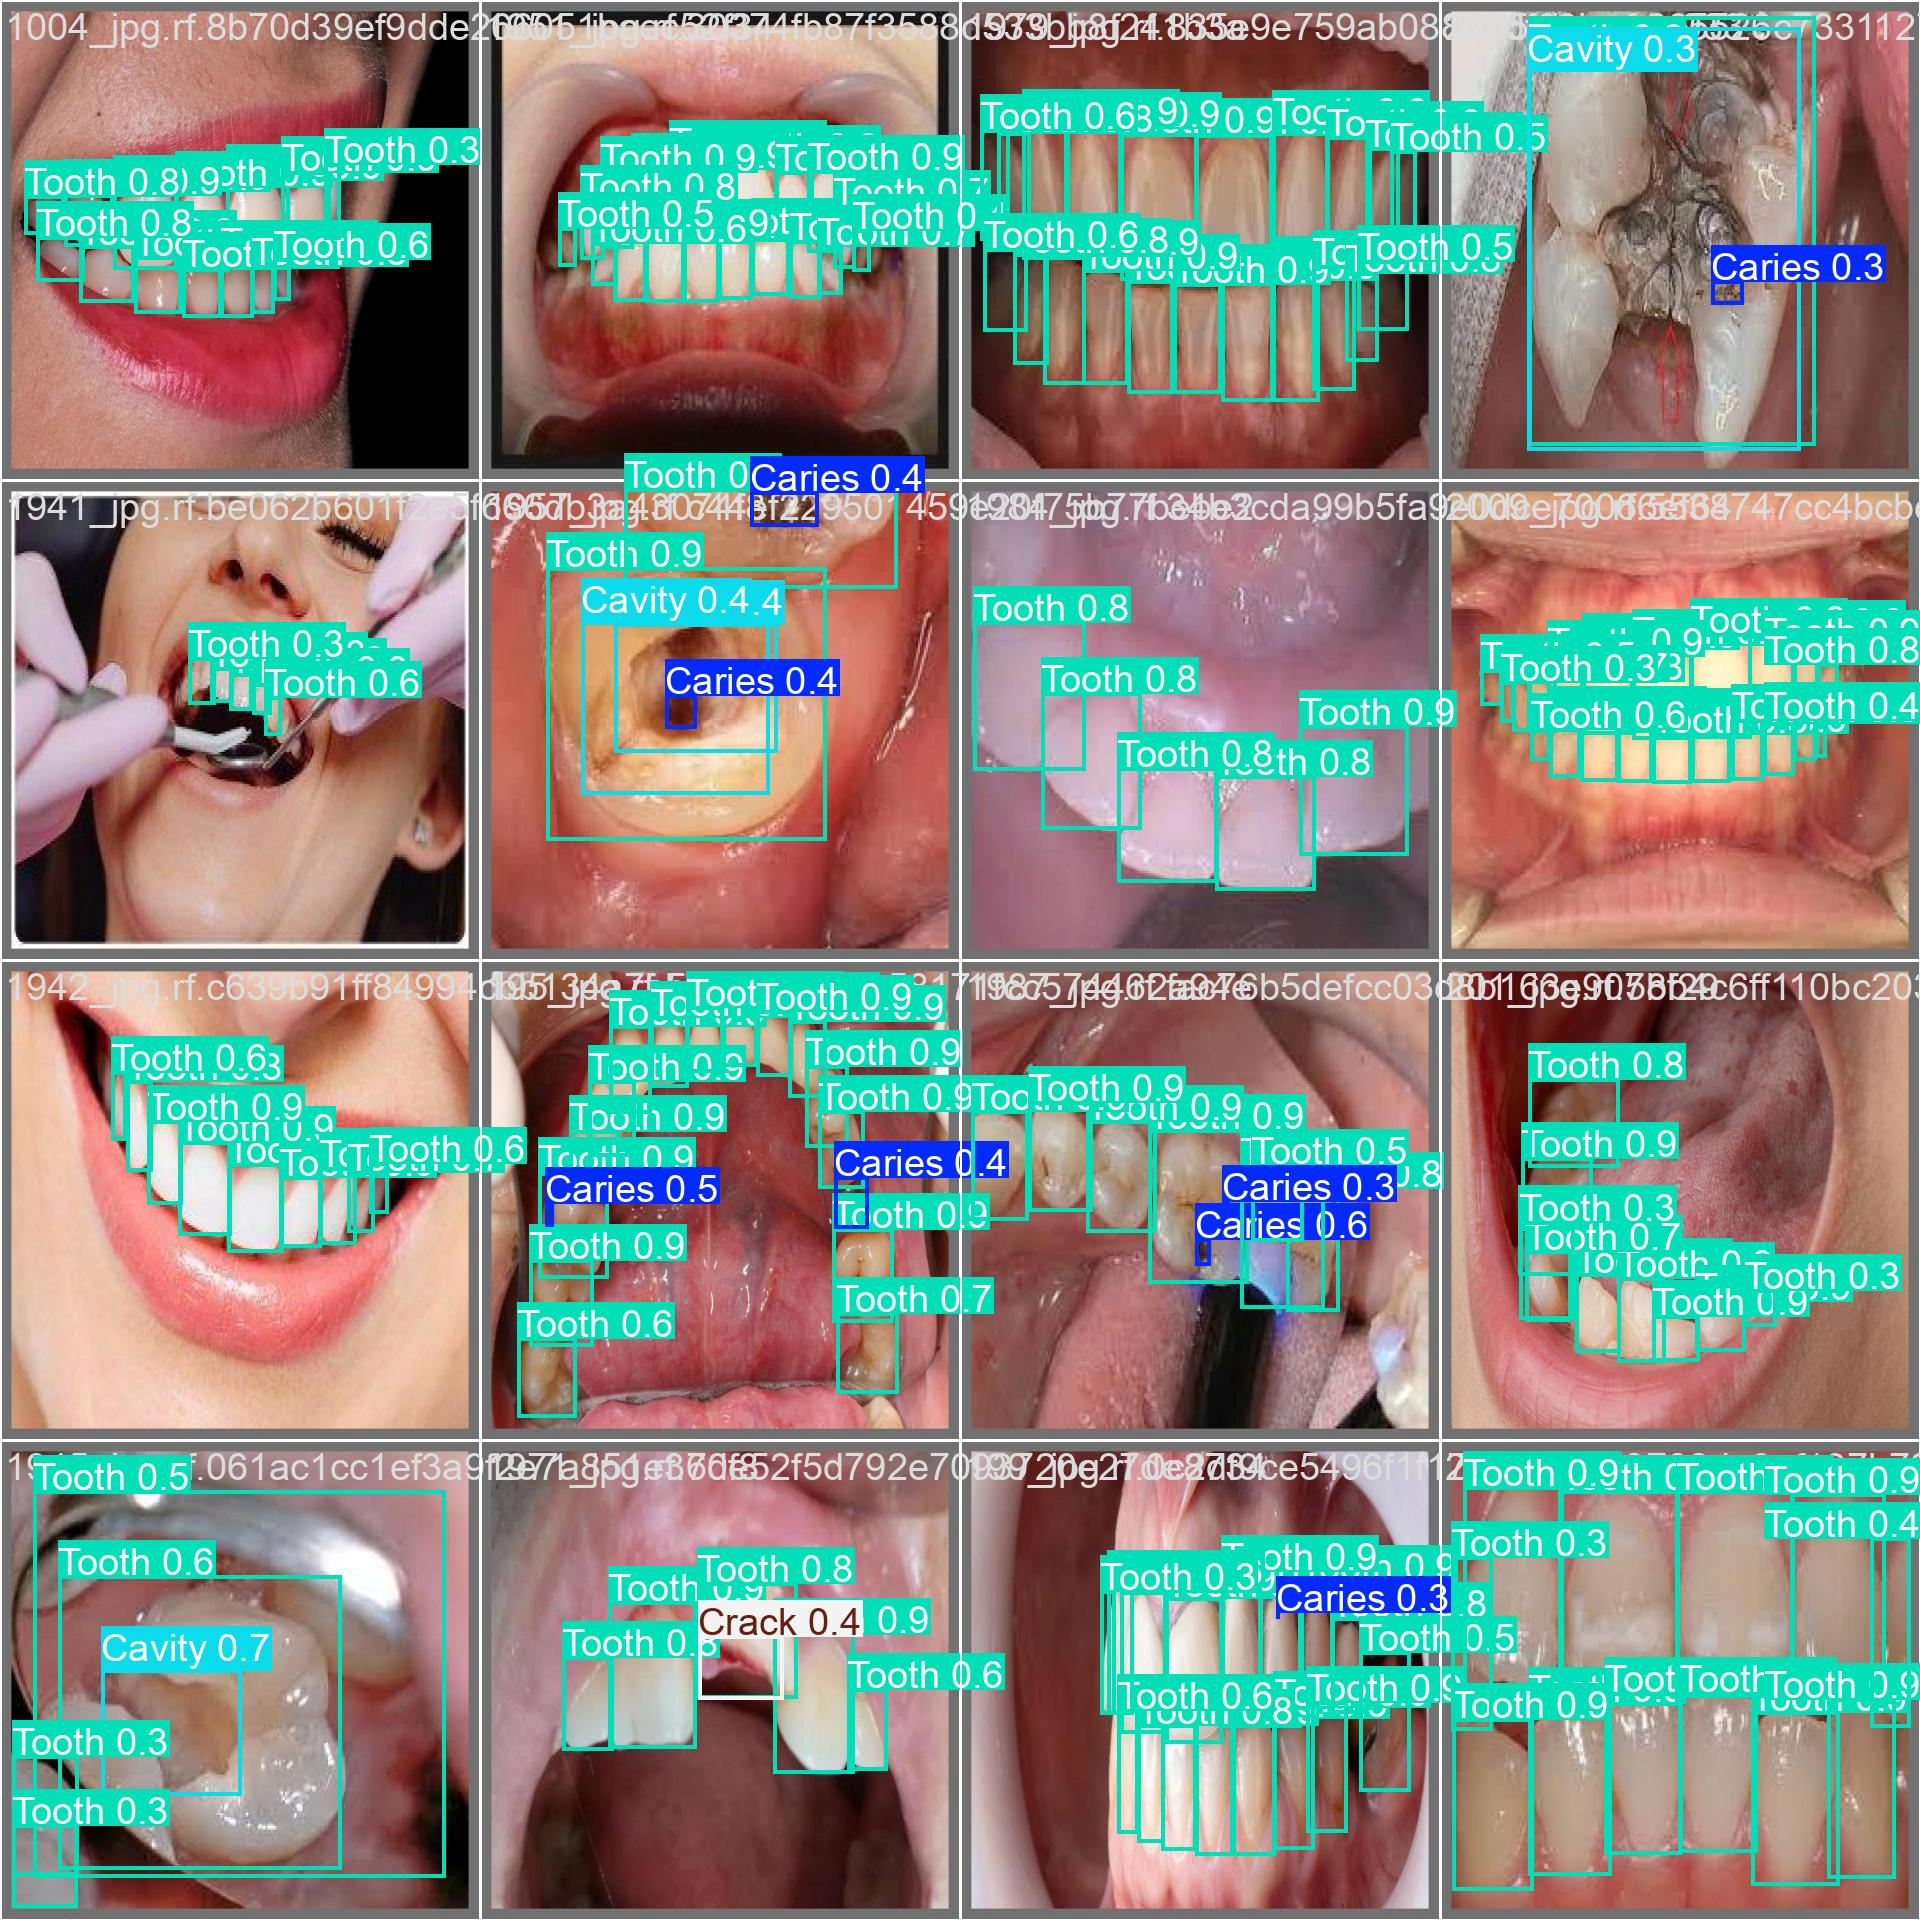

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/Dental-1/valid/labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100% 254/254 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 16/16 [00:06<00:00,  2.47it/s]
                   all        254       3156      0.491      0.473      0.452      0.315
                Caries        102        328      0.411      0.293      0.266      0.122
                Cavity         85        159      0.352      0.369      0.312      0.159
                 Crack         12         16      0.381       0.25      0.255      0.136
                 Tooth        254       2653      0.819      0.979      0.973      0.841
Speed: 1.8ms preprocess, 9.0ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://do

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

image 1/250 /content/Dental-1/test/images/1012_jpg.rf.bef19a24036edf51990be0853f3c2fc8.jpg: 640x640 17 Cariess, 1 Cavity, 4 Tooths, 15.6ms
image 2/250 /content/Dental-1/test/images/103_jpg.rf.8822ddbf5e9b4fbe2887bb10e3075990.jpg: 640x640 16 Tooths, 16.9ms
image 3/250 /content/Dental-1/test/images/1047_jpg.rf.c600b6d22a45fa0fd2492c5d2e7c6bbb.jpg: 640x640 1 Cavity, 2 Tooths, 15.6ms
image 4/250 /content/Dental-1/test/images/1048_jpg.rf.f2f6e7d0c4fa67b40781948afc060e6d.jpg: 640x640 5 Cariess, 6 Tooths, 15.6ms
image 5/250 /content/Dental-1/test/images/1052_jpg.rf.bad0fcaf9b422757b2022786de1933e2.jpg: 640x640 1 Caries, 6 Tooths, 15.5ms
image 6/250 /content/Dental-1/test/images/1070_jpg.rf.76e18a6b02ea3788f258dd5e808ebdb3.jpg: 640x640 3 Cariess, 7 Tooths, 15.5ms
image 7/250 /content/Dental-1/test/images/107_jpg.rf.1c45a800e87c2a

**NOTE:** Let's take a look at few results.

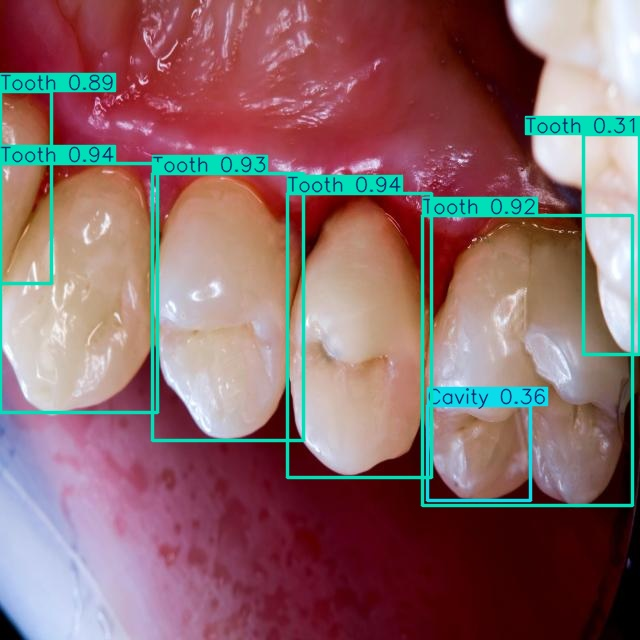

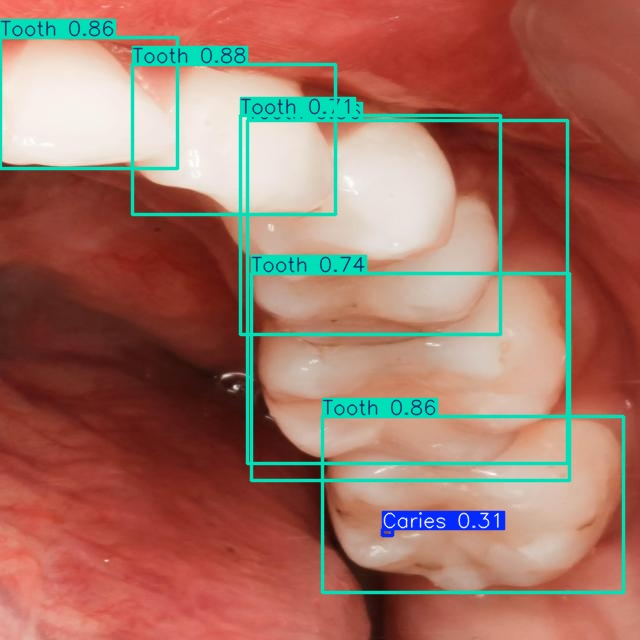

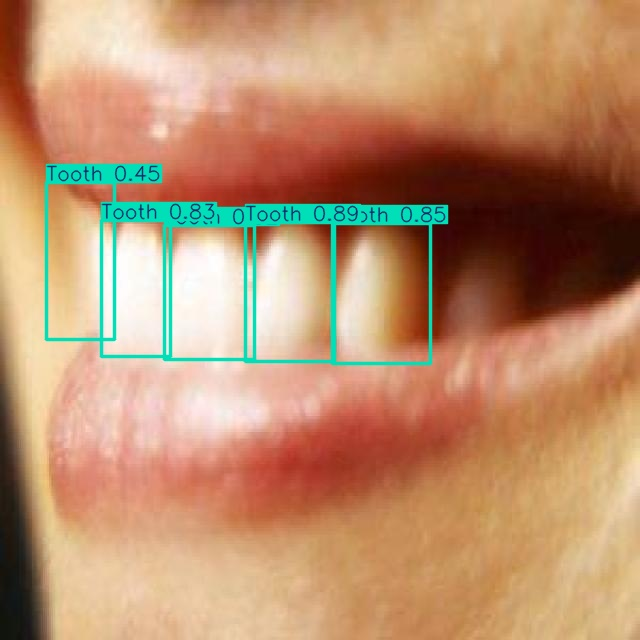

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.